In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="GfoCaZXpeaozAglH6pMn")
project = rf.workspace("yolo-rrhld").project("square_pick")
version = project.version(2)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 3.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to square_pick-2 in yolov11:: 100%|█| 854/854 [00:00<00:00, 6494.24it/s


In [24]:
from pyspark.sql import SparkSession
import os
import requests

# Khởi tạo SparkSession với YARN
spark = SparkSession.builder \
    .appName("Upload Data to HDFS via WebHDFS") \
    .master("spark://spark-master:7077") \
    .master("yarn") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9000") \
    .getOrCreate()

# Đường dẫn cục bộ đến thư mục chứa ảnh
local_dir = "/home/fit/square_pick-2/all_images"
# Thư mục đích trên HDFS
hdfs_dir = "/user/fit/all_images"
# URL WebHDFS của NameNode
webhdfs_url = "http://hadoop-namenode:9870/webhdfs/v1"

# Hàm để ghi từng file hoặc thư mục lên HDFS (chạy trên driver)
def save_to_hdfs(local_path, hdfs_path):
    if os.path.isdir(local_path):
        # Nếu là thư mục, tạo thư mục trên HDFS và tải các tệp bên trong
        dir_name = os.path.basename(local_path)
        hdfs_dir_path = f"{hdfs_path.rstrip('/')}/{dir_name}"
        mkdir_url = f"{webhdfs_url}{hdfs_dir_path}?op=MKDIRS"
        response = requests.put(mkdir_url)
        if response.status_code == 200:
            print(f"Successfully created directory {hdfs_dir_path} on HDFS")
            # Lặp qua các tệp và thư mục con bên trong để tải lên
            for item in os.listdir(local_path):
                item_path = os.path.join(local_path, item)
                save_to_hdfs(item_path, hdfs_dir_path)
        else:
            print(f"Failed to create directory {hdfs_dir_path} on HDFS. Status code: {response.status_code}, Message: {response.text}")
    else:
        # Nếu là tệp, tải tệp lên HDFS
        file_name = os.path.basename(local_path)
        hdfs_file_path = f"{hdfs_path.rstrip('/')}/{file_name}"
        upload_url = f"{webhdfs_url}{hdfs_file_path}?op=CREATE&overwrite=true"
        with open(local_path, "rb") as f:
            file_content = f.read()
        response = requests.put(upload_url, headers={"Content-Type": "application/octet-stream"}, data=file_content)
        if response.status_code == 201:
            print(f"Successfully uploaded {file_name} to HDFS")
        else:
            print(f"Failed to upload {file_name} to HDFS. Status code: {response.status_code}, Message: {response.text}")

# Gọi hàm để tải toàn bộ thư mục và các tệp lên HDFS
save_to_hdfs(local_dir, hdfs_dir)

# Dừng SparkSession
spark.stop()

# Cảnh báo về spark.yarn.jars
print("WARN: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.")

24/11/20 16:13:14 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


Successfully created directory /user/fit/all_images/all_images on HDFS
Successfully uploaded image_0420.jpg to HDFS
Successfully uploaded image_0342.jpg to HDFS
Successfully uploaded image_0091.jpg to HDFS
Successfully uploaded image_0286.jpg to HDFS
Successfully uploaded image_0246.jpg to HDFS
Successfully uploaded image_0207.jpg to HDFS
Successfully uploaded image_0236.jpg to HDFS
Successfully uploaded image_0405.jpg to HDFS
Successfully uploaded image_0366.jpg to HDFS
Successfully uploaded image_0002.jpg to HDFS
Successfully uploaded image_0341.jpg to HDFS
Successfully uploaded image_0409.jpg to HDFS
Successfully uploaded image_0186.jpg to HDFS
Successfully uploaded image_0343.jpg to HDFS
Successfully uploaded image_0232.jpg to HDFS
Successfully uploaded image_0223.jpg to HDFS
Successfully uploaded image_0276.jpg to HDFS
Successfully uploaded image_0009.jpg to HDFS
Successfully uploaded image_0060.jpg to HDFS
Successfully uploaded image_0160.jpg to HDFS
Successfully uploaded image_0

In [8]:
# from pyspark.sql import SparkSession
# from PIL import Image
# import requests
# import io
# import os
# import time

# # Khởi tạo SparkSession với YARN
# spark = SparkSession.builder \
#     .appName("Resize and Upload Images to HDFS via WebHDFS") \
#     .master("spark://spark-master:7077") \
#     .config("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9000") \
#     .getOrCreate()

# # Thư mục nguồn trên HDFS
# hdfs_source_dir = "/user/fit/all_images"
# # Thư mục đích trên HDFS
# hdfs_target_dir = "/user/fit/processed_all_images/"
# # URL WebHDFS của NameNode
# webhdfs_url = "http://hadoop-namenode:9870/webhdfs/v1"

# # Hàm để lấy danh sách các tệp từ WebHDFS (đệ quy)
# def list_files_in_hdfs(hdfs_path):
#     list_url = f"{webhdfs_url}{hdfs_path}?op=LISTSTATUS"
#     response = requests.get(list_url)
#     if response.status_code == 200:
#         file_statuses = response.json()["FileStatuses"]["FileStatus"]
#         files = []
#         for file in file_statuses:
#             full_path = f"{hdfs_path.rstrip('/')}/{file['pathSuffix']}"
#             if file['type'] == 'FILE':
#                 files.append(full_path)
#             elif file['type'] == 'DIRECTORY':
#                 files.extend(list_files_in_hdfs(full_path))
#         return files
#     else:
#         print(f"Failed to list files in HDFS directory {hdfs_path}. Status code: {response.status_code}, Message: {response.text}")
#         return []

# # Hàm để tải tệp từ HDFS về
# def download_file_from_hdfs(hdfs_file_path):
#     download_url = f"{webhdfs_url}{hdfs_file_path}?op=OPEN"
#     response = requests.get(download_url, stream=True)
#     if response.status_code == 200:
#         return response.content
#     else:
#         print(f"Failed to download file {hdfs_file_path} from HDFS. Status code: {response.status_code}, Message: {response.text}")
#         return None

# # Hàm để thay đổi kích thước ảnh
# def resize_image(image_content, output_size=(256, 256)):
#     try:
#         # Mở ảnh từ nội dung nhị phân bằng Pillow
#         img = Image.open(io.BytesIO(image_content))
#         img_resized = img.resize(output_size)
#         # Tạo buffer để lưu ảnh dưới dạng nhị phân
#         buffer = io.BytesIO()
#         img_resized.save(buffer, format=img.format)
#         return buffer.getvalue()
#     except Exception as e:
#         print(f"Failed to resize image. Error: {e}")
#         return None

# # Hàm để tải ảnh đã thay đổi kích thước lên HDFS
# def upload_file_to_hdfs(file_content, hdfs_file_path):
#     upload_url = f"{webhdfs_url}{hdfs_file_path}?op=CREATE&overwrite=true"
#     response = requests.put(upload_url, headers={"Content-Type": "application/octet-stream"}, data=file_content)
#     if response.status_code == 201:
#         print(f"Successfully uploaded {hdfs_file_path} to HDFS")
#     else:
#         print(f"Failed to upload {hdfs_file_path} to HDFS. Status code: {response.status_code}, Message: {response.text}")

# # Lấy danh sách tất cả các tệp trong thư mục nguồn trên HDFS (đệ quy)
# hdfs_files = list_files_in_hdfs(hdfs_source_dir)

# # Lặp qua từng tệp, tải về, thay đổi kích thước và tải lên thư mục đích trên HDFS
# for hdfs_file_path in hdfs_files:
#     if not hdfs_file_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
#         print(f"Skipping non-image file: {hdfs_file_path}")
#         continue

#     start_time = time.time()
#     file_content = download_file_from_hdfs(hdfs_file_path)
#     if file_content:
#         # Kiểm tra kích thước của tệp trước khi xử lý
#         print(f"Processing file: {hdfs_file_path}, Size: {len(file_content)} bytes")

#         # Thay đổi kích thước ảnh
#         resized_content = resize_image(file_content)
#         if resized_content:
#             target_file_path = hdfs_file_path.replace(hdfs_source_dir.rstrip('/'), hdfs_target_dir.rstrip('/'))
#             upload_file_to_hdfs(resized_content, target_file_path)

#     end_time = time.time()
#     print(f"Finished processing file: {hdfs_file_path}, Time taken: {end_time - start_time:.2f} seconds")

# # Dừng SparkSession
# spark.stop()

# # Kết thúc chương trình
# print("All files have been processed.")
# print("End...")

Skipping non-image file: /datasets/square_pick-2/README.dataset.txt
Skipping non-image file: /datasets/square_pick-2/README.roboflow.txt
Skipping non-image file: /datasets/square_pick-2/data.yaml
Processing file: /datasets/square_pick-2/test/images/-trashed-1732195572-1729603572053-gallery-delete-07storage08emulated01004DCIM06Camera17IMG_20241022_212606_jpg.rf.45a06ad8e805b35a1f2b128a1438719e.jpg, Size: 22766 bytes
Successfully uploaded /user/fit/processed_datasets/square_pick-2/test/images/-trashed-1732195572-1729603572053-gallery-delete-07storage08emulated01004DCIM06Camera17IMG_20241022_212606_jpg.rf.45a06ad8e805b35a1f2b128a1438719e.jpg to HDFS
Finished processing file: /datasets/square_pick-2/test/images/-trashed-1732195572-1729603572053-gallery-delete-07storage08emulated01004DCIM06Camera17IMG_20241022_212606_jpg.rf.45a06ad8e805b35a1f2b128a1438719e.jpg, Time taken: 0.83 seconds
Processing file: /datasets/square_pick-2/test/images/-trashed-1732195817-1729603817426-gallery-delete-07st

In [21]:
import requests
import io
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

# URL WebHDFS của NameNode
webhdfs_url = "http://hadoop-namenode:9870/webhdfs/v1"

# Thư mục nguồn trên HDFS
hdfs_source_dir = "/datasets/square_pick-2"

# Hàm để tải tệp từ HDFS về
def download_file_from_hdfs(hdfs_file_path):
    download_url = f"{webhdfs_url}{hdfs_file_path}?op=OPEN"
    response = requests.get(download_url, stream=True)
    if response.status_code == 200:
        content_type = response.headers.get('Content-Type')
        if content_type and 'image' in content_type.lower():
            return response.content
        else:
            print(f"Invalid content type {content_type} for file {hdfs_file_path}")
            return None
    else:
        print(f"Failed to download file {hdfs_file_path} from HDFS. Status code: {response.status_code}, Message: {response.text}")
        return None

# Lấy tệp ảnh từ thư mục gốc
def get_first_file_in_hdfs_directory(hdfs_dir):
    list_url = f"{webhdfs_url}{hdfs_dir}?op=LISTSTATUS"
    response = requests.get(list_url)
    if response.status_code == 200:
        file_statuses = response.json().get("FileStatuses", {}).get("FileStatus", [])
        for file in file_statuses:
            if file.get("type") == "FILE" and file['pathSuffix'].lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                return f"{hdfs_dir}/{file['pathSuffix']}"
    else:
        print(f"Failed to list files in directory {hdfs_dir}. Status code: {response.status_code}, Message: {response.text}")
    return None

original_image_path = get_first_file_in_hdfs_directory(hdfs_source_dir)

# Tải ảnh gốc
original_image_content = download_file_from_hdfs(original_image_path)

# Hiển thị ảnh gốc
if original_image_content:
    try:
        original_image = Image.open(io.BytesIO(original_image_content))

        # Hiển thị ảnh
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis("off")
        plt.show()

        # Hiển thị thông tin cơ bản của ảnh
        print("Original Image Info:")
        print(f"Format: {original_image.format}")
        print(f"Size: {original_image.size}")
        print(f"Mode: {original_image.mode}")
    except UnidentifiedImageError as e:
        print(f"Failed to identify image. Error: {e}")
        print(f"Original image path: {original_image_path}")
        print("Original image content length:", len(original_image_content))
else:
    print("Failed to load image for display.")
    if not original_image_content:
        print(f"Failed to load original image from path: {original_image_path}")


Failed to download file None from HDFS. Status code: 404, Message: <html>
<head>
<meta http-equiv="Content-Type" content="text/html;charset=ISO-8859-1"/>
<title>Error 404 Not Found</title>
</head>
<body><h2>HTTP ERROR 404 Not Found</h2>
<table>
<tr><th>URI:</th><td>/webhdfs/v1None</td></tr>
<tr><th>STATUS:</th><td>404</td></tr>
<tr><th>MESSAGE:</th><td>Not Found</td></tr>
<tr><th>SERVLET:</th><td>org.apache.hadoop.http.WebServlet-2a5b3fee</td></tr>
</table>

</body>
</html>

Failed to load image for display.
Failed to load original image from path: None


Processing file: /user/fit/all_images/all_images/.ipynb_checkpoints/image_0001-checkpoint.jpg, Size: 103982 bytes


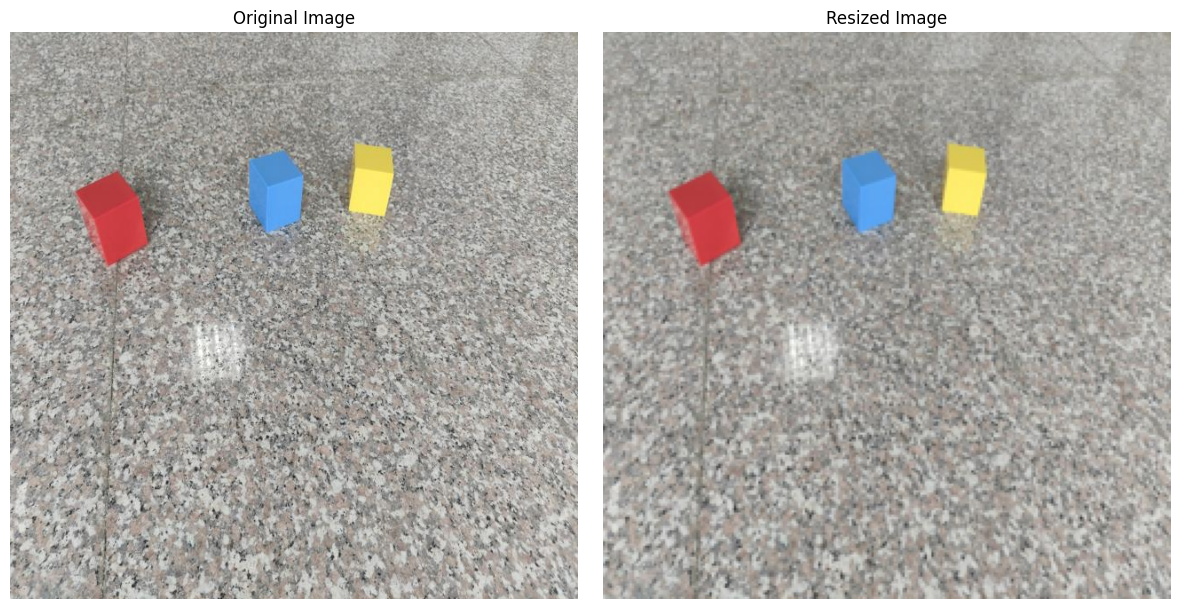

Original Image Info:
Format: JPEG
Size: (640, 640)
Mode: RGB

Resized Image Info:
Format: None
Size: (256, 256)
Mode: RGB
Successfully uploaded /user/fit/processed_all_images/all_images/.ipynb_checkpoints/image_0001-checkpoint.jpg to HDFS
Finished processing file: /user/fit/all_images/all_images/.ipynb_checkpoints/image_0001-checkpoint.jpg, Time taken: 1.39 seconds
Processing file: /user/fit/all_images/all_images/image_0001.jpg, Size: 103982 bytes
Successfully uploaded /user/fit/processed_all_images/all_images/image_0001.jpg to HDFS
Finished processing file: /user/fit/all_images/all_images/image_0001.jpg, Time taken: 0.28 seconds
Processing file: /user/fit/all_images/all_images/image_0002.jpg, Size: 54986 bytes
Successfully uploaded /user/fit/processed_all_images/all_images/image_0002.jpg to HDFS
Finished processing file: /user/fit/all_images/all_images/image_0002.jpg, Time taken: 0.47 seconds
Processing file: /user/fit/all_images/all_images/image_0003.jpg, Size: 46059 bytes
Successful

In [25]:
from pyspark.sql import SparkSession
from PIL import Image, UnidentifiedImageError
import requests
import io
import os
import time
import matplotlib.pyplot as plt

# Khởi tạo SparkSession với YARN
spark = SparkSession.builder \
    .appName("Resize and Upload Images to HDFS via WebHDFS") \
    .master("spark://spark-master:7077") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9000") \
    .getOrCreate()

# Thư mục nguồn trên HDFS
hdfs_source_dir = "/user/fit/all_images"
# Thư mục đích trên HDFS
hdfs_target_dir = "/user/fit/processed_all_images/"
# URL WebHDFS của NameNode
webhdfs_url = "http://hadoop-namenode:9870/webhdfs/v1"

# Hàm để lấy danh sách các tệp từ WebHDFS (đệ quy)
def list_files_in_hdfs(hdfs_path):
    list_url = f"{webhdfs_url}{hdfs_path}?op=LISTSTATUS"
    response = requests.get(list_url)
    if response.status_code == 200:
        file_statuses = response.json()["FileStatuses"]["FileStatus"]
        files = []
        for file in file_statuses:
            full_path = f"{hdfs_path.rstrip('/')}/{file['pathSuffix']}"
            if file['type'] == 'FILE':
                files.append(full_path)
            elif file['type'] == 'DIRECTORY':
                files.extend(list_files_in_hdfs(full_path))
        return files
    else:
        print(f"Failed to list files in HDFS directory {hdfs_path}. Status code: {response.status_code}, Message: {response.text}")
        return []

# Hàm để tải tệp từ HDFS về
def download_file_from_hdfs(hdfs_file_path):
    download_url = f"{webhdfs_url}{hdfs_file_path}?op=OPEN"
    response = requests.get(download_url, stream=True)
    if response.status_code == 200:
        return response.content
    else:
        print(f"Failed to download file {hdfs_file_path} from HDFS. Status code: {response.status_code}, Message: {response.text}")
        return None

# Hàm để thay đổi kích thước ảnh
def resize_image(image_content, output_size=(256, 256)):
    try:
        # Mở ảnh từ nội dung nhị phân bằng Pillow
        img = Image.open(io.BytesIO(image_content))
        img_resized = img.resize(output_size)
        # Tạo buffer để lưu ảnh dưới dạng nhị phân
        buffer = io.BytesIO()
        img_resized.save(buffer, format=img.format)
        return buffer.getvalue(), img, img_resized
    except Exception as e:
        print(f"Failed to resize image. Error: {e}")
        return None, None, None

# Hàm để tải ảnh đã thay đổi kích thước lên HDFS
def upload_file_to_hdfs(file_content, hdfs_file_path):
    upload_url = f"{webhdfs_url}{hdfs_file_path}?op=CREATE&overwrite=true"
    response = requests.put(upload_url, headers={"Content-Type": "application/octet-stream"}, data=file_content)
    if response.status_code == 201:
        print(f"Successfully uploaded {hdfs_file_path} to HDFS")
    else:
        print(f"Failed to upload {hdfs_file_path} to HDFS. Status code: {response.status_code}, Message: {response.text}")

# Lấy danh sách tất cả các tệp trong thư mục nguồn trên HDFS (đệ quy)
hdfs_files = list_files_in_hdfs(hdfs_source_dir)

# Lặp qua từng tệp, tải về, thay đổi kích thước và tải lên thư mục đích trên HDFS
for i, hdfs_file_path in enumerate(hdfs_files):
    if not hdfs_file_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        print(f"Skipping non-image file: {hdfs_file_path}")
        continue

    start_time = time.time()
    file_content = download_file_from_hdfs(hdfs_file_path)
    if file_content:
        # Kiểm tra kích thước của tệp trước khi xử lý
        print(f"Processing file: {hdfs_file_path}, Size: {len(file_content)} bytes")

        # Thay đổi kích thước ảnh
        resized_content, original_image, resized_image = resize_image(file_content)
        if resized_content:
            # Hiển thị ảnh đầu tiên trước và sau khi thay đổi kích thước
            if i == 0:
                try:
                    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                    axes[0].imshow(original_image)
                    axes[0].set_title("Original Image")
                    axes[0].axis("off")

                    axes[1].imshow(resized_image)
                    axes[1].set_title("Resized Image")
                    axes[1].axis("off")

                    plt.tight_layout()
                    plt.show()

                    # In thông tin của ảnh
                    print("Original Image Info:")
                    print(f"Format: {original_image.format}")
                    print(f"Size: {original_image.size}")
                    print(f"Mode: {original_image.mode}")
                    print("\nResized Image Info:")
                    print(f"Format: {resized_image.format}")
                    print(f"Size: {resized_image.size}")
                    print(f"Mode: {resized_image.mode}")
                except UnidentifiedImageError as e:
                    print(f"Failed to identify image for display. Error: {e}")

            # Tải ảnh đã thay đổi kích thước lên HDFS
            target_file_path = hdfs_file_path.replace(hdfs_source_dir.rstrip('/'), hdfs_target_dir.rstrip('/'))
            upload_file_to_hdfs(resized_content, target_file_path)

    end_time = time.time()
    print(f"Finished processing file: {hdfs_file_path}, Time taken: {end_time - start_time:.2f} seconds")

# Dừng SparkSession
spark.stop()

# Kết thúc chương trình
print("All files have been processed.")
print("End...")
